<a href="https://colab.research.google.com/github/GrzegorzMeller/AlgorithmsForMassiveData/blob/master/OCULAR_DISEASE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

In [4]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob

BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

training_images_file = 'ODIR-5K/Training Images'
testing_images_file = 'ODIR-5K/Testing Images'
labels_file = 'ODIR-5K/data.xlsx'

#load labels to pandas
labels = pd.read_excel(labels_file, index_col=0) 
labels['Left-Diagnostic Keywords'][0]

'cataract'

In [0]:
def update_filenames(file_path):
  all_paths = []
  for element in glob.glob(file_path+"/*.jpg"):
    all_paths.append(element)
  paths = []

  for u_id in labels.index:
    labelL = ""
    labelR = ""
    if ("normal fundus") in labels['Left-Diagnostic Keywords'][u_id]:
      labelL = "N"
    elif labels['D'][u_id] == 1:
      labelL = "D"
    elif labels['G'][u_id] == 1:
      labelL = "G"
    elif labels['C'][u_id] == 1:
      labelL = "C"
    elif labels['A'][u_id] == 1:
      labelL = "A"
    elif labels['H'][u_id] == 1:
      labelL = "H"
    elif labels['M'][u_id] == 1:
      labelL = "M"
    elif labels['O'][u_id] == 1:
      labelL = "O"

    if file_path+"/"+str(labels['Left-Fundus'][u_id]) in all_paths:
      filename = str(labels['Left-Fundus'][u_id]).split(".")
      os.rename(file_path+"/"+str(labels['Left-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelL+".jpg")
      paths.append(file_path+"/"+str(labels['Left-Fundus'][u_id])+"/"+labelL)

    if ("normal fundus") in labels['Right-Diagnostic Keywords'][u_id]:
      labelR = "N"
    elif labels['D'][u_id] == 1:
      labelR = "D"
    elif labels['G'][u_id] == 1:
      labelR = "G"
    elif labels['C'][u_id] == 1:
      labelR = "C"
    elif labels['A'][u_id] == 1:
      labelR = "A"
    elif labels['H'][u_id] == 1:
      labelR = "H"
    elif labels['M'][u_id] == 1:
      labelR = "M"
    elif labels['O'][u_id] == 1:
      labelR = "O"
  
    if file_path+"/"+str(labels['Right-Fundus'][u_id]) in all_paths:
      filename = str(labels['Right-Fundus'][u_id]).split(".")
      os.rename(file_path+"/"+str(labels['Right-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelR+".jpg")
      paths.append(file_path+"/"+str(labels['Right-Fundus'][u_id])+"/"+labelR)
      
update_filenames(training_images_file)

In [0]:
import random
#move randomly selected 1000 files to Validation Images directory
all_paths = []
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  all_paths.append(element)
num_to_select = 1000                          
list_of_random_items = random.sample(all_paths, num_to_select)
for element in list_of_random_items:
  p = element.split("/")
  os.replace(element, "ODIR-5K/Validation_Images/"+p[-1])

In [0]:
train_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [8]:
for f in train_ds.take(5):
  print(f.numpy())

for f in test_ds.take(5):
  print(f.numpy())

b'ODIR-5K/Training Images/4355_left-N.jpg'
b'ODIR-5K/Training Images/2125_right-N.jpg'
b'ODIR-5K/Training Images/327_right-D.jpg'
b'ODIR-5K/Training Images/2404_left-N.jpg'
b'ODIR-5K/Training Images/4125_left-D.jpg'
b'ODIR-5K/Validation_Images/3181_left-N.jpg'
b'ODIR-5K/Validation_Images/449_right-O.jpg'
b'ODIR-5K/Validation_Images/1421_left-G.jpg'
b'ODIR-5K/Validation_Images/1050_right-O.jpg'
b'ODIR-5K/Validation_Images/3243_left-N.jpg'


In [0]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  l = 0
  if label[0] == 'N':
    l = 0
  elif label[0] == 'D':
    l = 1
  elif label[0] == 'G':
    l = 2
  elif label[0] == 'C':
    l = 3
  elif label[0] == 'A':
    l = 4
  elif label[0] == 'H':
    l = 5
  elif label[0] == 'M':
    l = 6
  else:
    l = 7
  return l #== CLASS_NAMES

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 3)
  #img = tf.image.rgb_to_grayscale(img)
  # Normalize the pixel values
  #image = image / 255.0
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_named_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(32, 32, 3)
label:  4


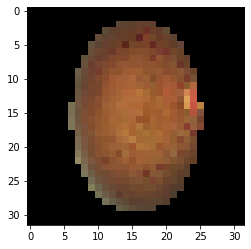

In [12]:
for image, label in train_named_ds.take(1):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', label.numpy())

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(train_named_ds,shuffle_buffer_size=6000)
test_ds = prepare_for_training(test_named_ds)

image_batch, label_batch = next(iter(train_ds))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')

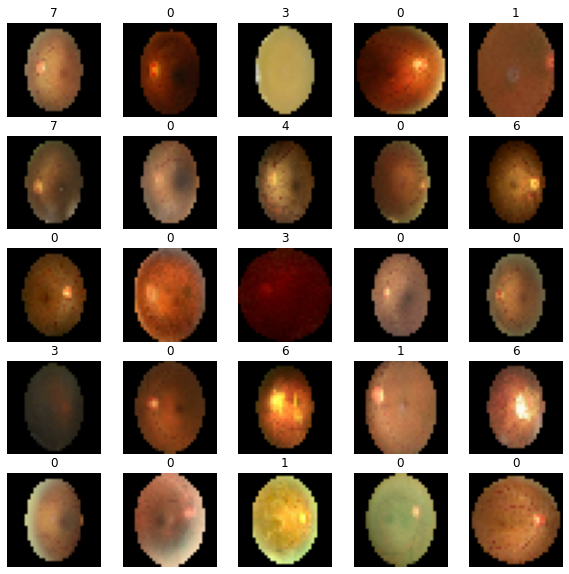

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [21]:
#calculating class weights
total = 3500
weight_for_N = (1 / 1140)*(total)/2.0 
weight_for_D = (1 / 1120)*(total)/2.0
weight_for_G = (1 / 215)*(total)/2.0
weight_for_C = (1 / 212)*(total)/2.0
weight_for_A = (1 / 164)*(total)/2.0
weight_for_H = (1 / 103)*(total)/2.0
weight_for_M = (1 / 174)*(total)/2.0
weight_for_O = (1 / 979)*(total)/2.0

class_weight = {0 : weight_for_N, 1 : weight_for_D, 2 : weight_for_G, 3 : weight_for_C, 4 : weight_for_A, 5 : weight_for_H, 6 : weight_for_M, 7 : weight_for_O}
print(class_weight)

{0: 1.5350877192982457, 1: 1.5625, 2: 8.13953488372093, 3: 8.254716981132075, 4: 10.670731707317074, 5: 16.99029126213592, 6: 10.057471264367816, 7: 1.787538304392237}


In [25]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (3, 3), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(8, activation = 'softmax')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        96        
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        96        
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)       

In [26]:
history_cnn = model_cnn.fit(train_ds.repeat(),
                    #batch_size=32,
                    epochs=100,
                    steps_per_epoch = 187, #train_elements/batch_size
                    validation_data=test_ds.repeat(),
                    validation_steps = 35,
                    #class_weight=class_weight
                    )

Epoch 1/100
187/187 [==============================] - 1s 6ms/step - loss: 4.8026 - accuracy: 0.3787 - val_loss: 1.6007 - val_accuracy: 0.4589
Epoch 2/100
187/187 [==============================] - 1s 6ms/step - loss: 1.5588 - accuracy: 0.4352 - val_loss: 1.4955 - val_accuracy: 0.4652
Epoch 3/100
187/187 [==============================] - 1s 6ms/step - loss: 1.4989 - accuracy: 0.4380 - val_loss: 1.4198 - val_accuracy: 0.4643
Epoch 4/100
187/187 [==============================] - 1s 6ms/step - loss: 1.4643 - accuracy: 0.4480 - val_loss: 1.4730 - val_accuracy: 0.4241
Epoch 5/100
187/187 [==============================] - 1s 6ms/step - loss: 1.4507 - accuracy: 0.4499 - val_loss: 1.4542 - val_accuracy: 0.4491
Epoch 6/100
187/187 [==============================] - 1s 6ms/step - loss: 1.4348 - accuracy: 0.4507 - val_loss: 1.6034 - val_accuracy: 0.4179
Epoch 7/100
187/187 [==============================] - 1s 6ms/step - loss: 1.4295 - accuracy: 0.4544 - val_loss: 1.3957 - val_accuracy: 0.4759

In [0]:
!rm -rf ODIR-5K/